# Evaluation of SOLFSMY

> With respect to the benchmark by Licata et al.

In [27]:
# Imports
import sys
sys.path.append('..')
from swdf.benchmark import *
from tsai.basics import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
from swdf.utils import *
import wandb
from swdf.losses import *
wandb_api = wandb.Api()

In [28]:
tsai.__version__

'0.3.10'

In [29]:
# Constants
# ARTIFACT_DOWNLOAD_PATH = Path(os.environ["WANDB_DIR"])/"wandb/artifacts/solfsmy_eval_tmp"

In [30]:
# Config
config = yaml2dict('config/solfsmy.yaml')
config = config.eval
config_base = yaml2dict('config/base.yaml')

config, config_base

({'dst_data_path': '../data/DST_IAGA2002.txt',
  'learner_artifact': None,
  'round_preds': True,
  'solfsmy_data_path': '../data/SOLFSMY.TXT'},
 {'arch_name': 'PatchTST',
  'arch_config_file': 'config/patchtst.yaml',
  'bs': 32,
  'horizon': 6,
  'init_weights': False,
  'lookback': 24,
  'lr_max': None,
  'n_epoch': 300,
  'partial_n': 0.1,
  'seed': 42,
  'test_start_datetime': '2012-10-01 12:00:00',
  'test_end_datetime': '2018-12-31 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'deltaHL': 4.0,
  'is_optuna_study': False,
  'wandb': {'enabled': False,
   'log_learner': True,
   'mode': 'offline',
   'group': None,
   'project': 'swdf'}})

In [31]:
# TODO
# learn.path = Path(path)
# learn.model_dir = Path()
if config.learner_artifact is None:
    learner_path = 'tmp'
else:
    learner_path = wandb_api.artifact(config.learner_artifact).download(root=ARTIFACT_DOWNLOAD_PATH)
learn = load_learner_all(learner_path, model_fname = 'model', 
                         verbose=True, 
                         device=default_device())

Learner loaded:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [32]:
# Print the test loss
print(f'Test loss: {learn.validate(ds_idx=2)[0]}')

Test loss: 168.2509307861328


In [33]:
y_test_preds, y_test = learn.get_preds(ds_idx = 2, with_targs=True)
y_test_preds = to_np(y_test_preds)
y_test = to_np(y_test)
print(f"y_test_preds.shape: {y_test_preds.shape}")     

y_test_preds.shape: (2242, 4, 6)


In [34]:
horizon = y_test.shape[-1]
data_columns_fcst = ['F10', 'S10', 'M10', 'Y10']

The evaluation is done for each variable separately, for each solar activity 
level (low, moderate, elevated and high), as in the paper by Licata et al. (2020)
Therefore, the test set has to be split into 4 different sets, one for each solar activity level. The thresholds for each solar activity level are the same as in the paper by Licata et al. (2020)

The thresholds are:
- F10: 75, 150, 190
- S10: 65, 150, 215
- M10: 72, 144, 167
- Y10: 81, 148, 165

In [35]:
#|export

def get_idxs_per_solar_activity_level(data, thresholds):
    # function that splits the data of a variable into 4 different sets, 
    # one for each solar activity level. The data comes as a numpy array with 
    # shape (samples, steps), and the split is done along the samples axis. 
    # The decision is made based on the first column of each sample. The function 
    # returns a list of 4 numpy arrays, one for each solar activity level. 
    # But it does not return the values, it returns the indices of the
    # samples that belong to each solar activity level.
    idxs_per_solar_activity_level = []
    for i in range(len(thresholds) + 1):
        if i == 0:
            idxs = np.where(data[:, 0] <= thresholds[i])[0]
        elif i == len(thresholds):
            idxs = np.where(data[:, 0] > thresholds[i-1])[0]
        else:
            idxs = np.where((data[:, 0] > thresholds[i-1]) & (data[:, 0] <= thresholds[i]))[0]
        idxs_per_solar_activity_level.append(idxs)
    return idxs_per_solar_activity_level

In [36]:
# Call the function for each variable, using y_test
thresholds = {'F10': [75, 150, 190], 
              'S10': [65, 150, 215], 
              'M10': [72, 144, 167], 
              'Y10': [81, 148, 165]}

y_test_split_idxs = {}
for i, var in enumerate(data_columns_fcst):
    y_test_split_idxs[var] = get_idxs_per_solar_activity_level(y_test[:-1, i, :], 
                                                               thresholds[var])
# Check the shape of each variable
for var in data_columns_fcst:
    print(f"{var}: {[y_test_split_idxs[var][i].shape for i in range(4)]}")

F10: [(590,), (1423,), (205,), (23,)]
S10: [(495,), (1463,), (283,), (0,)]
M10: [(524,), (1469,), (226,), (22,)]
Y10: [(486,), (1654,), (97,), (4,)]


In [37]:
df_SET = pd.read_pickle('preprocessed_data/dataframes/set_solfsmy.pkl')

lookback = learn.xb[0].shape[2] # length of the input sequence
_, y_test_SET = SlidingWindow(
            window_len=lookback,
            horizon=config_base.horizon, 
            stride=1, 
            get_x=['S10'], 
            get_y=['S10']
        )(df_SET)

y_test_split_idxs['S10'] = get_idxs_per_solar_activity_level(y_test_SET, thresholds['S10'])

# Check the shape of each variable
for var in data_columns_fcst:
    print(f"{var}: {[y_test_split_idxs[var][i].shape for i in range(4)]}")

F10: [(590,), (1423,), (205,), (23,)]
S10: [(520,), (1421,), (267,), (33,)]
M10: [(524,), (1469,), (226,), (22,)]
Y10: [(486,), (1654,), (97,), (4,)]


In [38]:
# Now split y_test and y_test_preds with the idxs we got, using numpy.take
y_test_split = {}
y_test_preds_split = {}
for var in data_columns_fcst:
    y_test_split[var] = [y_test[:, i, :].take(y_test_split_idxs[var][i], axis=0) for i in range(4)]
    y_test_preds_split[var] = [y_test_preds[:, i, :].take(y_test_split_idxs[var][i], axis=0) for i in range(4)]

# Check the shape of each variable in y_test_split
for var in data_columns_fcst:
    print(f"y_test-{var}: {[y_test_split[var][i].shape for i in range(4)]}")
    print(f"y_test_preds-{var}: {[y_test_preds_split[var][i].shape for i in range(4)]}")

y_test-F10: [(590, 6), (1423, 6), (205, 6), (23, 6)]
y_test_preds-F10: [(590, 6), (1423, 6), (205, 6), (23, 6)]
y_test-S10: [(520, 6), (1421, 6), (267, 6), (33, 6)]
y_test_preds-S10: [(520, 6), (1421, 6), (267, 6), (33, 6)]
y_test-M10: [(524, 6), (1469, 6), (226, 6), (22, 6)]
y_test_preds-M10: [(524, 6), (1469, 6), (226, 6), (22, 6)]
y_test-Y10: [(486, 6), (1654, 6), (97, 6), (4, 6)]
y_test_preds-Y10: [(486, 6), (1654, 6), (97, 6), (4, 6)]


In [39]:
#| hide

# Test with random data (torch)
foo = torch.rand(10, 3)
bar = torch.rand(10, 3)
print(forecast_error(foo, bar, 1))
print(percent_forecast_error(foo, bar, 1))

tensor([-0.1433,  0.3172,  0.1485,  0.1552,  0.6058,  0.0428,  0.3811,  0.5700,
        -0.0804,  0.4203])
tensor([-80.1754,  48.9520,  42.4751,  40.2089, 242.7231, 541.7862, 190.6667,
        200.3487, -10.0196, 166.9478])


In [40]:
# Create a table (dataframe) with the mean forecast error for each variable (F10, S10, M10, Y10), 
# each solar activity level and each horizon (1..horizon)
data = []
sals = ['low', 'moderate', 'elevated', 'high']
for var_idx, var in enumerate(data_columns_fcst):
    for sal_idx,sal in enumerate(sals):
        for h in range(1, horizon+1):
            fe_sfu = forecast_error(y_test_split[var][sal_idx], 
                                y_test_preds_split[var][sal_idx], h)
            fe_percent = percent_forecast_error(y_test_split[var][sal_idx],
                                            y_test_preds_split[var][sal_idx], h)
            n_samples = y_test_split[var][sal_idx].shape[0]
            data.append([var, sal, h, np.mean(fe_sfu), np.std(fe_sfu), 
                        np.mean(fe_percent), np.std(fe_percent), n_samples])
df_results = pd.DataFrame(data, columns=['variable', 'condition', 'horizon', 
                                         'mean_sfu', 'std_sfu', 'mean_percent', 
                                         'std_percent', 'n_samples'])
df_results.head(10)

,variable,condition,horizon,mean_sfu,std_sfu,mean_percent,std_percent,n_samples
0,F10,low,1,3.253738,4.805873,4.589653,6.724243,590
1,F10,low,2,3.373868,5.068427,4.767896,7.099781,590
2,F10,low,3,3.105974,5.007136,4.403657,6.999468,590
3,F10,low,4,3.078952,5.158440,4.376982,7.177101,590
4,F10,low,5,2.582694,5.085522,3.713050,7.016930,590
5,F10,low,6,2.159520,5.067459,3.155818,6.886213,590
6,F10,moderate,1,4.512391,11.058706,4.238934,9.538221,1423
7,F10,moderate,2,5.002614,11.553437,4.690754,9.966701,1423
8,F10,moderate,3,5.877519,12.164758,5.504648,10.506115,1423
9,F10,moderate,4,5.812614,12.649500,5.537772,10.894574,1423


In [41]:
# Divide the table into one dataframe for each variable, and print it in a way
# that has the same format as the table in the paper, that is:
# Columns: | Condition | Statistics | 1 Day | 2 Days | 3 Days | ... | {{horizon}} Days,
# where condition is the variable and the solar activity level, and statistics 
# is the mean (column mean_fe) and the standard deviation (std_fe) of the forecast error.
for i, var in enumerate(data_columns_fcst):
    df_var = df_results[df_results['variable'] == var]

    df_var = df_var.melt(id_vars=['condition', 'horizon'], 
                         value_vars=['mean_sfu', 'std_sfu'], 
                         var_name='Statistic')
    # Sort the values of the column condition so that the order is 
    # low, moderate, elevated, high
    df_var['condition'] = pd.Categorical(df_var['condition'], 
                                      categories=['low', 'moderate', 'elevated', 'high'], 
                                      ordered=True)
    df_var = df_var.pivot_table(index=['condition', 'Statistic'], 
                          columns='horizon', 
                          values='value')
    # pretty print, and separate with a blank line
    print(f'Distribution Statistics {var} Error Distribution \n{df_var.to_string()}\n')

Distribution Statistics F10 Error Distribution 
horizon                      1          2          3          4          5          6
condition Statistic                                                                  
low       mean_sfu    3.253738   3.373868   3.105974   3.078952   2.582694   2.159520
          std_sfu     4.805873   5.068427   5.007136   5.158440   5.085522   5.067459
moderate  mean_sfu    4.512391   5.002614   5.877519   5.812614   5.521978   6.130039
          std_sfu    11.058706  11.553437  12.164758  12.649500  13.077003  13.580264
elevated  mean_sfu   -9.529681 -10.195234  -8.988203  -8.201051  -6.765651  -4.427923
          std_sfu    11.818811  12.483844  13.378498  14.337095  15.198026  15.916893
high      mean_sfu  -13.050799 -12.839787 -12.722548 -11.083979  -7.879874  -4.370236
          std_sfu    10.312324  11.157993  10.977073  10.914246  11.740916  12.494695

Distribution Statistics S10 Error Distribution 
horizon                      1          2  

In [42]:
# Convert df_results into long format
df_results_lf = df_results.melt(id_vars=['variable', 'condition', 'horizon'],
                                value_vars=['mean_sfu', 'std_sfu', 'mean_percent', 'std_percent'],
                                var_name='statistic')

# Filter out the percent statistics
df_results_lf = df_results_lf[df_results_lf['statistic'].str.contains('percent') == False]

# Rename the Statistic 'mean_sfu' to just 'mean' and 'std_sfu' to 'std'
df_results_lf['statistic'] = df_results_lf['statistic'].str.replace('_sfu', '')

df_results_lf.head()

,variable,condition,horizon,statistic,value
0,F10,low,1,mean,3.253738
1,F10,low,2,mean,3.373868
2,F10,low,3,mean,3.105974
3,F10,low,4,mean,3.078952
4,F10,low,5,mean,2.582694


In [43]:
# Compare these results with the results in the paper. The results in the paper
# can be found in the data folder as a csv
df_results_paper = pd.read_csv('../data/paper_results.csv')

# Filter out the rows with Statistics = 'EBM'
df_results_paper = df_results_paper[df_results_paper['statistic'] != 'EBM']

# Rename the values of the column condition to the ones of the sals variable
df_results_paper['condition'] = df_results_paper['condition'].str.replace('Low solar', 'low')
df_results_paper['condition'] = df_results_paper['condition'].str.replace('Moderate solar', 'moderate')
df_results_paper['condition'] = df_results_paper['condition'].str.replace('Elevated solar', 'elevated')
df_results_paper['condition'] = df_results_paper['condition'].str.replace('High solar', 'high')

df_results_paper.head()

,variable,condition,statistic,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days
0,F10,low,mean,-0.2685,-0.7472,-0.6672,-0.3721,-0.0674,0.2428
1,F10,low,std,3.6985,4.7031,5.5001,6.1683,6.7677,7.2050
3,F10,moderate,mean,-0.8251,-0.8095,-0.9639,-1.1450,-1.1456,-1.1679
4,F10,moderate,std,12.0854,14.9853,17.8425,20.2973,21.9353,23.3389
6,F10,elevated,mean,5.7270,7.2425,9.0385,10.3829,11.0017,10.9559


In [44]:
# Convert df_results_paper into long format
df_results_paper_lf = df_results_paper.melt(id_vars=['variable', 'condition', 'statistic'],
                                            value_vars=[f'{i} Days' for i in range(1, horizon+1)],
                                            var_name='horizon', value_name='value')

# Convert the value sof the horizon column to int
df_results_paper_lf['horizon'] = df_results_paper_lf['horizon'].str.replace(' Days', '').astype(int)
df_results_paper_lf.head()

,variable,condition,statistic,horizon,value
0,F10,low,mean,1,-0.2685
1,F10,low,std,1,3.6985
2,F10,moderate,mean,1,-0.8251
3,F10,moderate,std,1,12.0854
4,F10,elevated,mean,1,5.7270


In [45]:
# Join the two dataframes (df_results_ours and df_results_paper) on the columns 
# variable, condition and Statistic
df_results_joined = df_results_lf.merge(df_results_paper_lf, how='left', 
                                            on=['variable', 'condition', 'statistic', 'horizon'],
                                            suffixes=('_ours', '_paper'))
len(df_results_lf), len(df_results_paper_lf), len(df_results_joined)

(192, 192, 192)

### Visualize predictions

In [46]:
df_long = df_results_paper.melt(id_vars=['variable', 'condition', 'statistic'], 
                      var_name='horizon', value_name='value')

df_long['horizon'] = df_long['horizon'].str.extract('(\d)').astype(int)
    
sfu_stats = df_long.groupby(['variable', 'condition','statistic', 'horizon']).agg(
        values=('value', 'mean')
    ).reset_index()

df_results_paper_formated = sfu_stats[['variable','condition','horizon']].iloc[np.where(sfu_stats['statistic'] == 'mean')]
df_results_paper_formated['std_percent'] = sfu_stats['values'].iloc[np.where(sfu_stats['statistic'] != 'mean')].values
df_results_paper_formated['mean_percent'] = sfu_stats['values'].iloc[np.where(sfu_stats['statistic'] == 'mean')].values
df_results_paper_formated['n_samples'] = np.nan
df_results_paper_formated['mean_sfu'] = np.nan
df_results_paper_formated['std_sfu'] = np.nan

df_results_paper_formated.reset_index()

,index,variable,condition,horizon,std_percent,mean_percent,n_samples,mean_sfu,std_sfu
0,0,F10,elevated,1,18.3328,5.7270,NaN,NaN,NaN
1,1,F10,elevated,2,22.1021,7.2425,NaN,NaN,NaN
2,2,F10,elevated,3,25.2942,9.0385,NaN,NaN,NaN
3,3,F10,elevated,4,27.0774,10.3829,NaN,NaN,NaN
4,4,F10,elevated,5,27.5279,11.0017,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
91,181,Y10,moderate,2,10.1811,-1.3317,NaN,NaN,NaN
92,182,Y10,moderate,3,11.8475,-1.7651,NaN,NaN,NaN
93,183,Y10,moderate,4,13.0170,-2.1734,NaN,NaN,NaN
94,184,Y10,moderate,5,13.8737,-2.5561,NaN,NaN,NaN


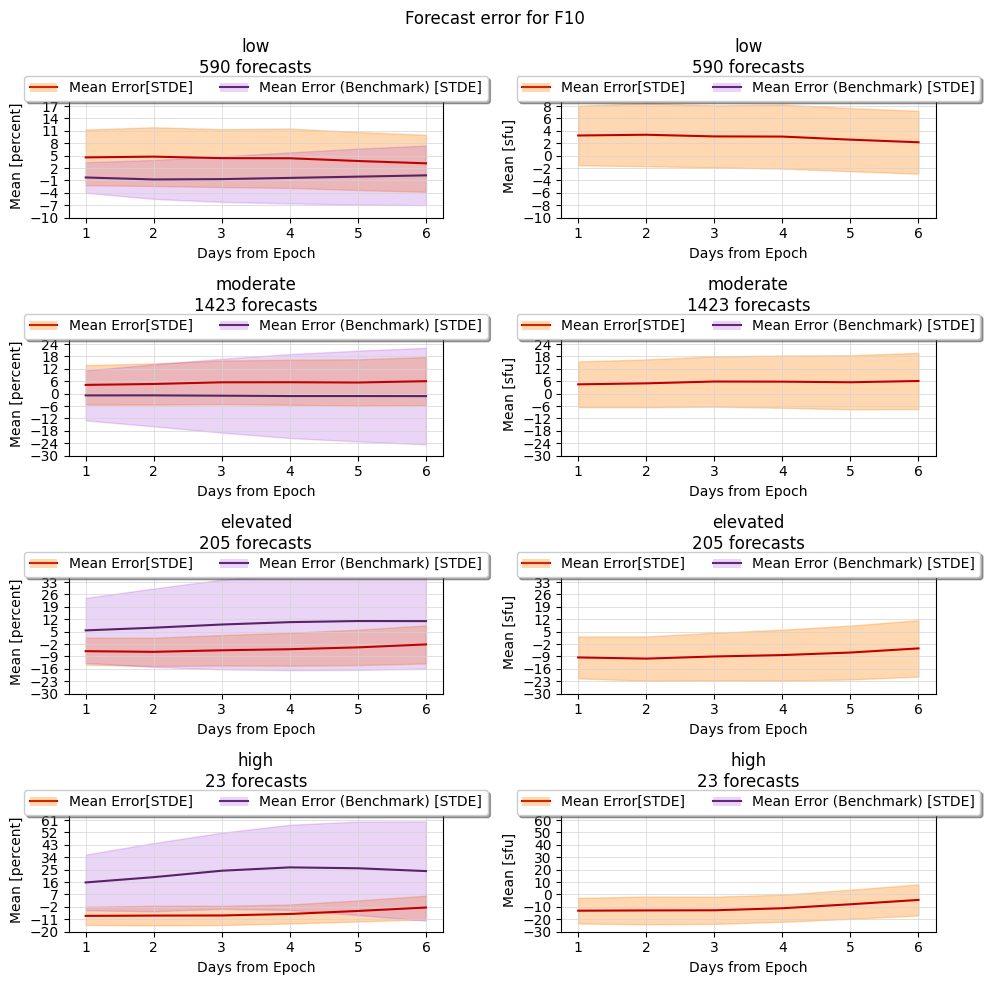

In [47]:
plot_solar_algorithm_performance_comparison(df_results, df_results_paper_formated, 'F10')

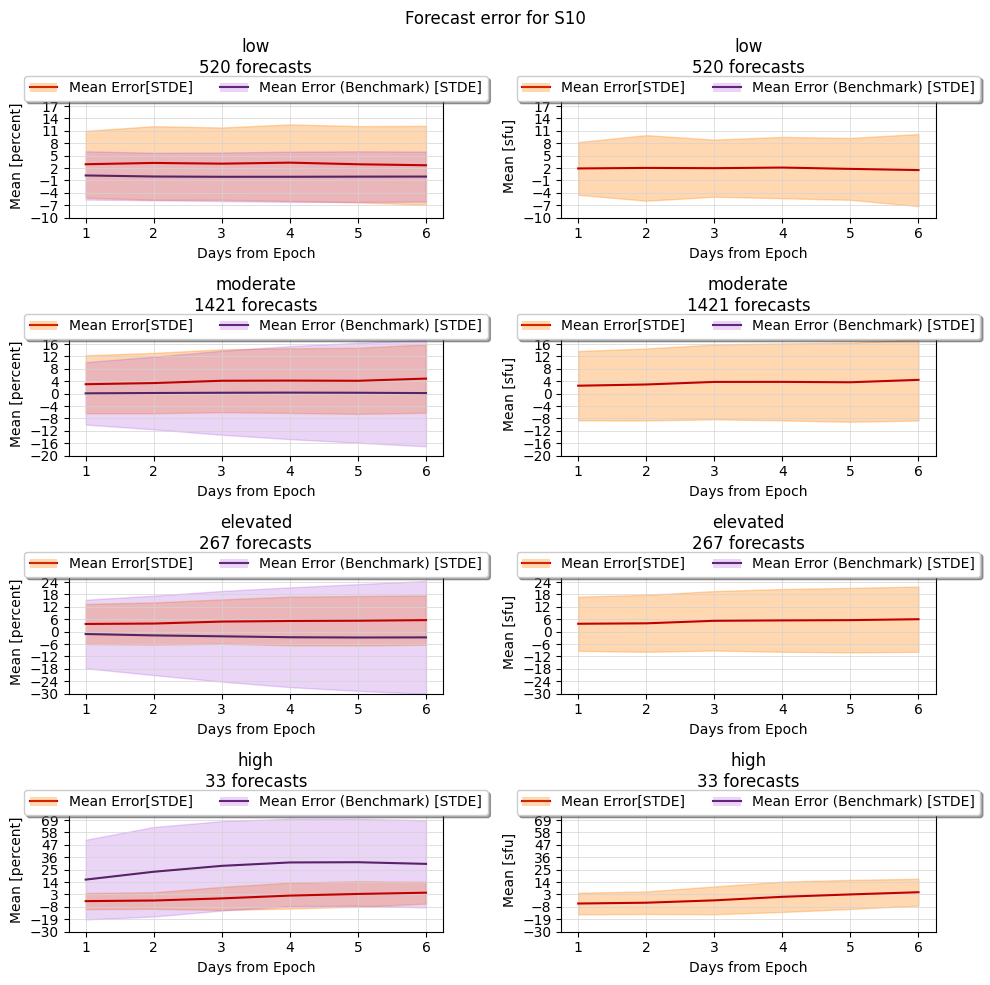

In [48]:
plot_solar_algorithm_performance_comparison(df_results, df_results_paper_formated, 'S10')

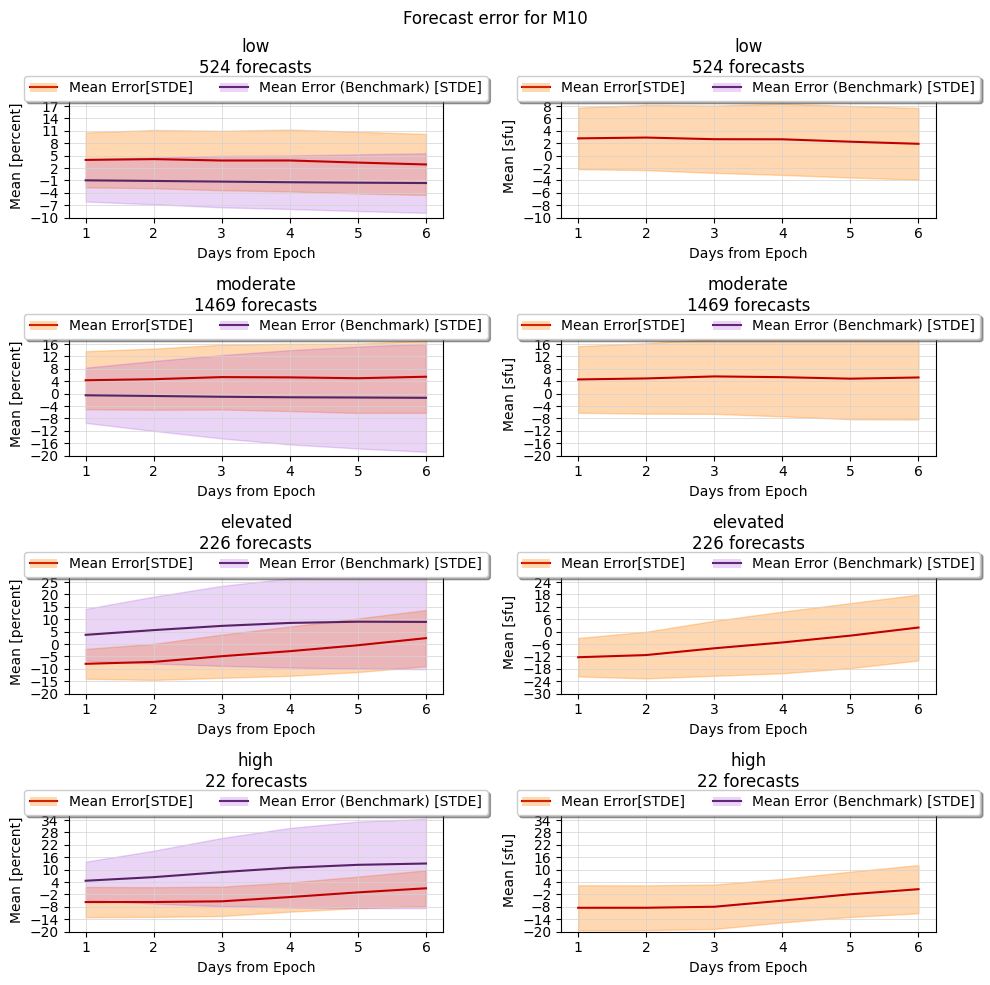

In [49]:
plot_solar_algorithm_performance_comparison(df_results, df_results_paper_formated, 'M10')

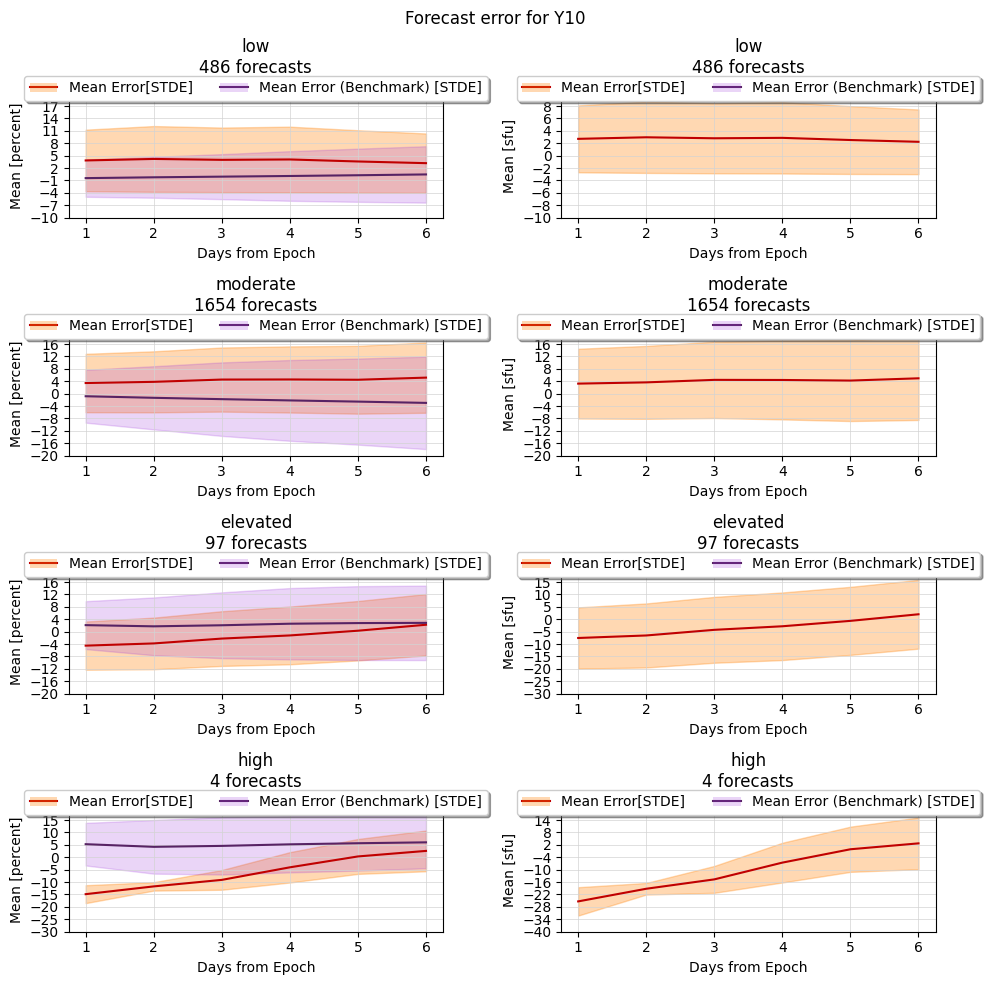

In [50]:
plot_solar_algorithm_performance_comparison(df_results, df_results_paper_formated, 'Y10')

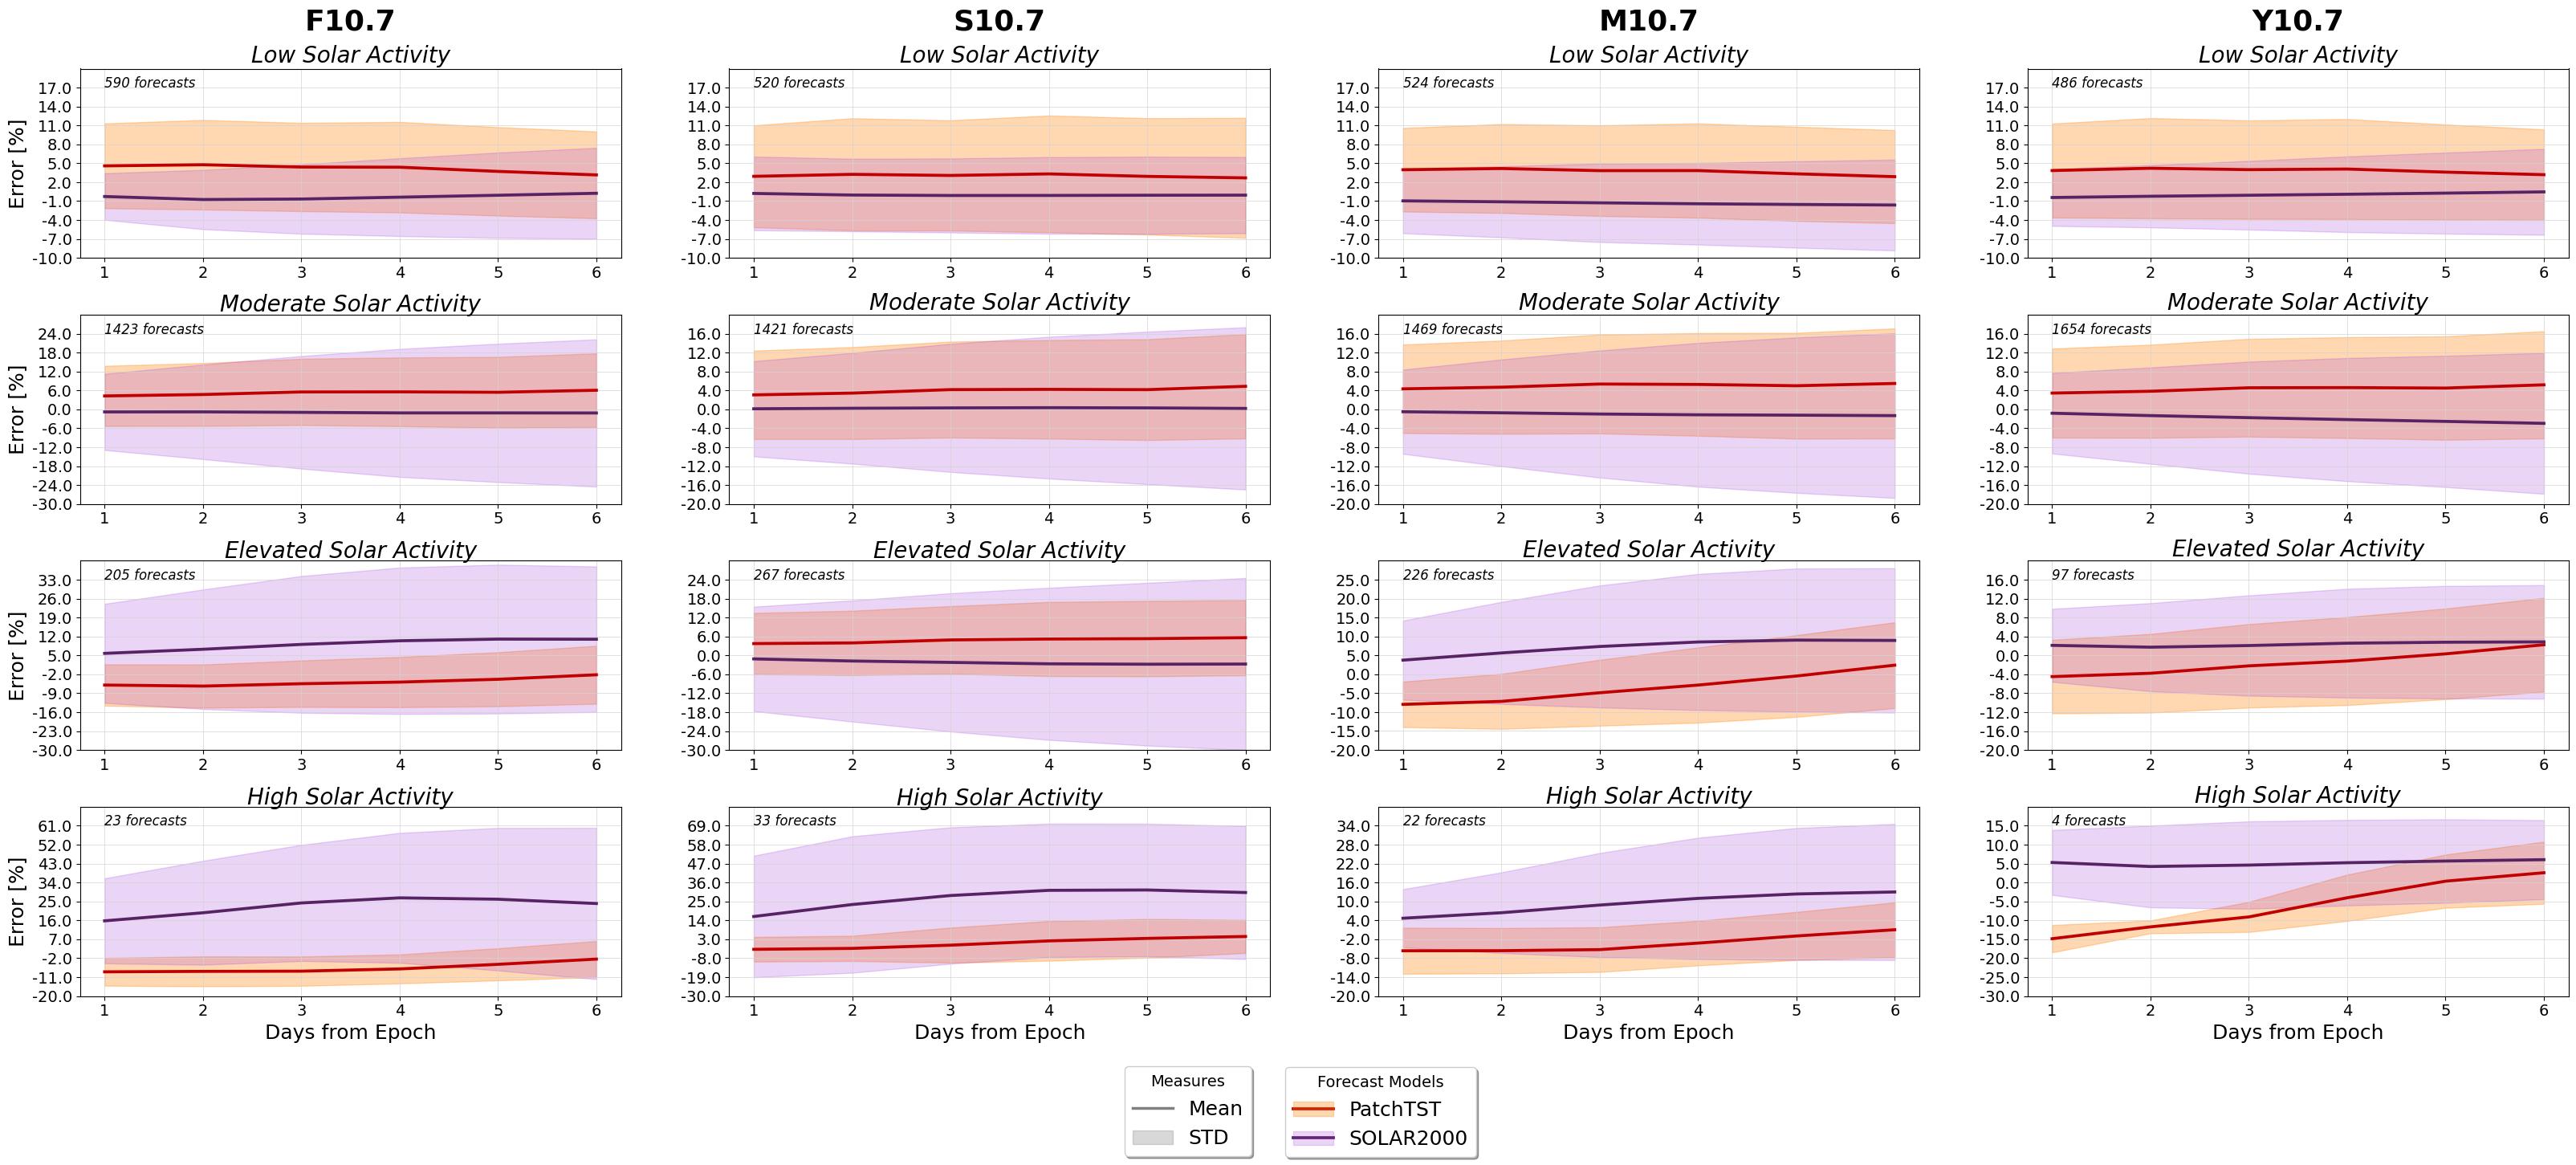

In [51]:
figure = plot_solar_algorithm_performance_all_indices(df_results, df_results_paper_formated, save_fig=True)

In [52]:
pivoted_df = df_results_joined.pivot_table(index=['variable', 'condition', 'statistic'], 
                            columns='horizon', 
                            values=['value_ours','value_paper'], 
                            aggfunc='first').reset_index()

# To order the columns in the way that we want
condition_order = ['low', 'moderate', 'elevated', 'high']
pivoted_df['condition'] = pd.Categorical(pivoted_df['condition'], categories=condition_order, ordered=True)

# Format columns names
pivoted_df.columns = pd.MultiIndex.from_tuples(
    list(pivoted_df.columns[:3]) + 
    [(value, f'{i} Days Horizon') for value in ['Value Ours', 'Value Benchmark'] for i in range(1,7)]
)

pivoted_df = pivoted_df.sort_values([('variable',''),('condition','')])
pivoted_df.head(1)

variable condition statistic     Value Ours                                \
                               1 Days Horizon 2 Days Horizon 3 Days Horizon   
4      F10       low      mean       3.253738       3.373868       3.105974   

                                               Value Benchmark                 \
  4 Days Horizon 5 Days Horizon 6 Days Horizon  1 Days Horizon 2 Days Horizon   
4       3.078952       2.582694        2.15952         -0.2685        -0.7472   

                                                               
  3 Days Horizon 4 Days Horizon 5 Days Horizon 6 Days Horizon  
4        -0.6672        -0.3721        -0.0674         0.2428

In [53]:
def highlight_max(row):
    # Empty color mask
    colors = [''] * len(row)
    columns = ['Value Ours', 'Value Benchmark']
    min_values = []
    
    for i in range(1,7):
        min_values.append(
            min(
                abs(row[('Value Ours', f'{i} Days Horizon')]), 
                abs(row[('Value Benchmark', f'{i} Days Horizon')])
            )
        )
    for i, value in enumerate(row[columns]):
        if np.abs(value) in min_values:
            colors[i+3] = 'background-color: grey'  # The 3 first columns are tags and no data
    return colors

# Compare and highlight # Get max of each element in both dataframes
styled_result = pivoted_df.style.apply(highlight_max, axis=1)

styled_result

In [54]:
create_latex_comparison_tables(df_results_joined, data_columns_fcst, horizon)

\begin{table}
\caption{Comparison of the results of the paper with the results of our model for the variable F10}
\label{tab:comparison_F10}
\begin{tabular}{|l||c||c||c||c||c||c|}
\toprule
condition & horizon & NN & benchmark \\
\midrule
low & 1 & 3.253738 ± 4.805873 & \textbf{-0.2685} ± \textbf{3.6985} \\
low & 2 & 3.3738682 ± 5.068427 & \textbf{-0.7472} ± \textbf{4.7031} \\
low & 3 & 3.105974 ± \textbf{5.007136} & \textbf{-0.6672} ± 5.5001 \\
low & 4 & 3.078952 ± \textbf{5.15844} & \textbf{-0.3721} ± 6.1683 \\
low & 5 & 2.5826936 ± \textbf{5.0855217} & \textbf{-0.0674} ± 6.7677 \\
low & 6 & 2.1595201 ± \textbf{5.067459} & \textbf{0.2428} ± 7.205 \\
moderate & 1 & 4.5123906 ± \textbf{11.058706} & \textbf{-0.8251} ± 12.0854 \\
moderate & 2 & 5.002614 ± \textbf{11.553437} & \textbf{-0.8095} ± 14.9853 \\
moderate & 3 & 5.8775187 ± \textbf{12.164758} & \textbf{-0.9639} ± 17.8425 \\
moderate & 4 & 5.812614 ± \textbf{12.6495} & \textbf{-1.145} ± 20.2973 \\
moderate & 5 & 5.521978 ± \textbf{